# OHLCV Training (DVC + MLflow)

This notebook:
- Clones the repo (so Git + DVC pointers are available)
- Pulls the DVC-versioned OHLCV feature table
- Uses metadata-driven global time splits
- Trains an OHLCV baseline model and logs full data/code lineage to MLflow


In [1]:
# Install deps (Colab)
!pip -q install feast==0.58.0 s3fs boto3 pyarrow pandas scikit-learn "mlflow>=2.12,<3" "dagshub==0.6.4" "dvc[s3]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.3/113.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.5/

## 1) Credentials / Environment
Set these using Colab `userdata` (or replace with your own method).

In [2]:
import os
from google.colab import userdata

# AWS
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_DEFAULT_REGION'] = userdata.get('AWS_DEFAULT_REGION') or 'us-east-1'

# MLflow (DAGsHub)
os.environ["DAGSHUB_USER_TOKEN"] = userdata.get('DAGSHUB_TOKEN')

missing = [k for k in ['AWS_ACCESS_KEY_ID','AWS_SECRET_ACCESS_KEY','DAGSHUB_USER_TOKEN'] if not os.environ.get(k)]
if missing:
    raise ValueError(f"Missing secrets in Colab userdata: {missing}")
print('Secrets loaded:', ', '.join(['AWS_ACCESS_KEY_ID','AWS_SECRET_ACCESS_KEY','AWS_DEFAULT_REGION','DAGSHUB_USER_TOKEN']))

Secrets loaded: AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_DEFAULT_REGION, DAGSHUB_USER_TOKEN


## 2) Clone repo + pull DVC dataset
This ensures `git_sha` and `.dvc` pointers exist locally, and that the dataset version is reproducible.

In [3]:
from pathlib import Path

REPO_NAME = "dissertation"  # change if needed
REPO_URL = f"https://github.com/Roncool13/{REPO_NAME}.git"
BRANCH_OR_COMMIT = "main"  # or a specific commit hash for perfect reproducibility

if not Path(REPO_NAME).exists():
    !git clone {REPO_URL}
%cd {REPO_NAME}
!git checkout {BRANCH_OR_COMMIT}

# Pull DVC-versioned dataset artifacts
!dvc pull data/features/ohlcv_features.parquet
!dvc pull data/features/ohlcv_feature_metadata.json

%cd ..

Cloning into 'dissertation'...
remote: Enumerating objects: 984, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 984 (delta 63), reused 86 (delta 35), pack-reused 864 (from 1)
Receiving objects: 100% (984/984), 415.37 KiB | 8.65 MiB/s, done.
Resolving deltas: 100% (608/608), done.
/content/dissertation
Already on 'main'
Your branch is up to date with 'origin/main'.
Fetching
!
  0% |          |0/? [00:00<?,    ?files/s]
                                           
!
  0% |          |0/? [00:00<?,    ?files/s]
                                           
Fetching from s3:   0% 0/1 [00:00<?, ?file/s]
Fetching from s3:   0% 0/1 [00:00<?, ?file/s{'info': ''}]

  0% 0.00/17.4M [00:00<?, ?B/s]

  0% 0.00/17.4M [00:00<?, ?B/s{'info': ''}]

  6% 1.09M/17.4M [00:00<00:01, 11.2MB/s{'info': ''}]

 66% 11.4M/17.4M [00:00<00:00, 67.8MB/s{'info': ''}]

                                                    
Fetching from s3: 100% 1/1 [00

## 3) MLflow setup

In [4]:
import mlflow
import dagshub

dagshub.init(repo_owner='Roncool13', repo_name='dissertation-mlflow', mlflow=True)
mlflow.set_experiment("dissertation-ohlcv-multisym-2019-2023")
mlflow.sklearn.autolog(disable=True)

print('MLflow tracking URI:', mlflow.get_tracking_uri())

Accessing as Roncool13

Initialized MLflow to track repo "Roncool13/dissertation-mlflow"

Repository Roncool13/dissertation-mlflow initialized!

MLflow tracking URI: https://dagshub.com/Roncool13/dissertation-mlflow.mlflow


## 4) Reproducibility + dataset lineage logging (Git + DVC)

In [5]:
import subprocess
import hashlib
import json
import numpy as np
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

def _run(cmd):
    return subprocess.check_output(cmd, text=True).strip()

def _sha256_file(path):
    h = hashlib.sha256()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(1024*1024), b''):
            h.update(chunk)
    return h.hexdigest()

def log_code_and_data_version():
    # Git commit
    try:
        mlflow.set_tag('git_sha', _run(['git','rev-parse','HEAD']))
    except Exception:
        mlflow.set_tag('git_sha', 'unavailable')

    # DVC pointer hashes (these change when the dataset changes)
    for tag, p in [
        ('dvc_ptr_features_sha256', f'{REPO_NAME}/data/features/ohlcv_features.parquet.dvc'),
        ('dvc_ptr_metadata_sha256', f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json.dvc'),
    ]:
        try:
            mlflow.set_tag(tag, _sha256_file(p))
        except Exception:
            mlflow.set_tag(tag, 'unavailable')

    # Log pointer files + metadata as artifacts (small, very useful)
    for p, ap in [
        (f'{REPO_NAME}/data/features/ohlcv_features.parquet.dvc', 'dataset_pointers'),
        (f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json.dvc', 'dataset_pointers'),
        (f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json', 'dataset_metadata'),
    ]:
        try:
            mlflow.log_artifact(p, artifact_path=ap)
        except Exception:
            pass

    # Log key metadata as params/tags
    meta = json.loads(Path(f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json').read_text())
    splits = meta.get('splits', {})

    mlflow.log_params({
        'dataset_name': 'ohlcv_features',
        'symbols_count': meta.get('symbols_count', len(meta.get('symbols', []))),
        'start_year': meta.get('start_year'),
        'end_year': meta.get('end_year'),
        'horizon_days': meta.get('horizon_days'),
        'lags': ','.join(map(str, meta.get('lags', []))),
        'split_scheme': splits.get('scheme'),
        'seed': SEED,
    })

    if 'train' in splits and 'val' in splits and 'test' in splits:
        mlflow.set_tags({
            'train_period': f"{splits['train']['start']}:{splits['train']['end']}",
            'val_period': f"{splits['val']['start']}:{splits['val']['end']}",
            'test_period': f"{splits['test']['start']}:{splits['test']['end']}",
        })

print('Seed set to', SEED)

Seed set to 42


## 5) Load dataset + apply metadata-driven splits

In [6]:
import pandas as pd

df = pd.read_parquet(f'{REPO_NAME}/data/features/ohlcv_features.parquet')
meta = json.loads(Path(f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json').read_text())

# Ensure date type
if not np.issubdtype(df['date'].dtype, np.datetime64):
    df['date'] = pd.to_datetime(df['date'])

splits = meta['splits']

def split_by_date(frame, split):
    start = pd.to_datetime(split['start'])
    end = pd.to_datetime(split['end'])
    return frame[(frame['date'] >= start) & (frame['date'] <= end)].copy()

train_df = split_by_date(df, splits['train'])
val_df   = split_by_date(df, splits['val'])
test_df  = split_by_date(df, splits['test'])

print('Shapes -> train/val/test:', train_df.shape, val_df.shape, test_df.shape)
label_col = f"y_up_{meta['horizon_days']}d" if 'horizon_days' in meta else 'y_up_5d'
print('Label col:', label_col)

for name, part in [('train',train_df),('val',val_df),('test',test_df)]:
    vc = part[label_col].value_counts(normalize=True).to_dict() if label_col in part.columns else {}
    print(name, 'class balance:', vc)

Shapes -> train/val/test: (15645, 90) (5208, 90) (5061, 90)
Label col: y_up_5d
train class balance: {1: 0.526941514860978, 0: 0.47305848513902204}
val class balance: {1: 0.5276497695852534, 0: 0.47235023041474655}
test class balance: {1: 0.5633274056510571, 0: 0.4366725943489429}


## 6) Build feature matrix (drop leakage columns)
We exclude:
- keys: `symbol`, `date`
- label: `y_up_*`
- forward-looking columns like `close_fwd_*` and `ret_fwd_*` (these leak)

In [7]:
# Feature selection for multi-symbol training (keep 'symbol' as a categorical feature)
# Exclude forward-looking columns to prevent leakage
exclude_prefixes = ('close_fwd_', 'ret_fwd_')
key_cols = {'date'}
cat_cols = ['symbol']

# Numeric feature columns (everything except keys/label/cat and forward-looking)
num_cols = [
    c for c in df.columns
    if c not in (key_cols | {label_col} | set(cat_cols)) and not c.startswith(exclude_prefixes)
]

X_cols = cat_cols + num_cols

# Drop any remaining NaNs in selected columns (should be minimal if pipeline already did it)
train_df = train_df.dropna(subset=X_cols + [label_col])
val_df   = val_df.dropna(subset=X_cols + [label_col])
test_df  = test_df.dropna(subset=X_cols + [label_col])

X_train, y_train = train_df[X_cols].copy(), train_df[label_col].astype(int).copy()
X_val, y_val     = val_df[X_cols].copy(),   val_df[label_col].astype(int).copy()
X_test, y_test   = test_df[X_cols].copy(),  test_df[label_col].astype(int).copy()

# Ensure consistent dtypes
for _X in (X_train, X_val, X_test):
    _X['symbol'] = _X['symbol'].astype(str)
    _X[num_cols] = _X[num_cols].astype('float32')

print('Categorical cols:', cat_cols)
print('Numeric features:', len(num_cols))
print('Train rows:', len(X_train), 'Val rows:', len(X_val), 'Test rows:', len(X_test))


Categorical cols: ['symbol']
Numeric features: 85
Train rows: 14847 Val rows: 5208 Test rows: 5061


In [8]:
## (Optional) Per-symbol normalization (train-only stats; applied to val/test)
USE_PER_SYMBOL_NORM = False

def per_symbol_standardize(train_df, val_df, test_df, num_cols, group_col='symbol'):
    """Standardize numeric columns *within each symbol* using TRAIN-only mean/std.
    Avoids leakage: stats are computed from train_df only.
    """
    train_df = train_df.copy()
    val_df   = val_df.copy()
    test_df  = test_df.copy()

    # Compute per-symbol mean/std on TRAIN
    stats = train_df.groupby(group_col)[num_cols].agg(['mean','std'])
    # Replace 0 std with 1 to avoid division by zero
    for c in num_cols:
        stats[(c,'std')] = stats[(c,'std')].replace(0, 1.0).fillna(1.0)

    def _apply(frame):
        out = frame.copy()
        # align symbols; unseen symbols (shouldn't happen) fall back to global stats
        global_mu = train_df[num_cols].mean()
        global_sd = train_df[num_cols].std().replace(0, 1.0).fillna(1.0)
        for sym, idx in out.groupby(group_col).groups.items():
            if sym in stats.index:
                mu = stats.loc[sym].xs('mean', level=1)
                sd = stats.loc[sym].xs('std', level=1)
            else:
                mu = global_mu
                sd = global_sd
            out.loc[idx, num_cols] = (out.loc[idx, num_cols] - mu.values) / sd.values
        return out

    train_df = _apply(train_df)
    val_df   = _apply(val_df)
    test_df  = _apply(test_df)
    return train_df, val_df, test_df, stats

if USE_PER_SYMBOL_NORM:
    train_df, val_df, test_df, sym_stats = per_symbol_standardize(train_df, val_df, test_df, num_cols, group_col='symbol')
    print('✅ Applied per-symbol normalization on numeric features (using TRAIN-only stats).')
    print('Example symbols in stats:', list(sym_stats.index)[:5])
else:
    print('Per-symbol normalization disabled; using global scaler in the model pipeline.')


Per-symbol normalization disabled; using global scaler in the model pipeline.


## 7) Train baseline model + evaluate
We train on Train, pick threshold 0.5 (baseline), and report metrics on Val and Test.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef
import numpy as np
import pandas as pd

# -----------------------------
# Preprocess (handles multi-symbol + optional per-symbol norm)
# -----------------------------
num_transform = "passthrough" if USE_PER_SYMBOL_NORM else StandardScaler()
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", num_transform, num_cols),
    ],
    remainder="drop",
    sparse_threshold=0.0,
)

base_pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1500, solver="liblinear", random_state=SEED)),
])

param_grid = {
    "clf__C": [0.001, 0.01, 0.1, 1.0, 10.0],
    "clf__penalty": ["l1", "l2"],
    "clf__class_weight": [None, "balanced"],
}

tscv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    refit=False,
    return_train_score=False,
)

# ---- 1) GridSearch CV on TRAIN only ----
grid.fit(X_train, y_train)

best_cv_idx = int(np.argmax(grid.cv_results_["mean_test_score"]))
best_cv_params = grid.cv_results_["params"][best_cv_idx]
best_cv_score = float(grid.cv_results_["mean_test_score"][best_cv_idx])

print("Best TRAIN-CV params:", best_cv_params)
print("Best TRAIN-CV mean ROC-AUC:", best_cv_score)

# ---- 2) Select final params using VAL (refit on TRAIN) ----
rows = []
for params in grid.cv_results_["params"]:
    model = Pipeline([
        ("preprocess", preprocess),
        ("clf", LogisticRegression(
            max_iter=1500,
            solver="liblinear",
            random_state=SEED,
            C=params["clf__C"],
            penalty=params["clf__penalty"],
            class_weight=params["clf__class_weight"],
        )),
    ])
    model.fit(X_train, y_train)
    val_proba = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_proba)
    rows.append({"val_roc_auc": float(val_auc), **params})

val_rank = pd.DataFrame(rows).sort_values("val_roc_auc", ascending=False).reset_index(drop=True)
best_val = val_rank.iloc[0].to_dict()
best_val_params = {k: best_val[k] for k in param_grid.keys()}
best_val_auc = float(best_val["val_roc_auc"])

print("\nBest VAL-selected params:", best_val_params)
print("Best VAL ROC-AUC:", best_val_auc)

# ---- 3) Refit final model on TRAIN+VAL with VAL-selected params ----
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = pd.concat([y_train, y_val], axis=0)

final_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=1500,
        solver="liblinear",
        random_state=SEED,
        C=best_val_params["clf__C"],
        penalty=best_val_params["clf__penalty"],
        class_weight=best_val_params["clf__class_weight"],
    )),
])

final_model.fit(X_trval, y_trval)


def eval_split(X, y, split_name):
    proba = final_model.predict_proba(X)[:, 1]
    pred = (proba >= 0.5).astype(int)
    metrics = {
        f"{split_name}_accuracy": float(accuracy_score(y, pred)),
        f"{split_name}_roc_auc": float(roc_auc_score(y, proba)),
        f"{split_name}_balanced_accuracy": float(balanced_accuracy_score(y, pred)),
        f"{split_name}_mcc": float(matthews_corrcoef(y, pred)),
    }
    return metrics, proba

val_metrics, val_proba = eval_split(X_val, y_val, "val_final")
test_metrics, test_proba = eval_split(X_test, y_test, "test")

print("\nVAL (final model):", val_metrics)
print("TEST:", test_metrics)

val_candidate_csv = "val_candidate_ranking_top10.csv"
val_rank.head(10).to_csv(val_candidate_csv, index=False)
print(f"Saved top-10 VAL ranking to {val_candidate_csv}. Run the next cell to log everything to MLflow.")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best TRAIN-CV params: {'clf__C': 0.01, 'clf__class_weight': None, 'clf__penalty': 'l1'}
Best TRAIN-CV mean ROC-AUC: 0.5155452696548009

Best VAL-selected params: {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__class_weight': None}
Best VAL ROC-AUC: 0.5261205488692442

VAL (final model): {'val_final_accuracy': 0.5295698924731183, 'val_final_roc_auc': 0.5406183062922332, 'val_final_balanced_accuracy': 0.5071874889054567, 'val_final_mcc': 0.02449203307084036}
TEST: {'test_accuracy': 0.5554238292827505, 'test_roc_auc': 0.5091643640161189, 'test_balanced_accuracy': 0.5039213834631335, 'test_mcc': 0.013401748970193214}
Saved top-10 VAL ranking to val_candidate_ranking_top10.csv. Run the next cell to log everything to MLflow.


In [10]:
display(val_rank.head(10))

,val_roc_auc,clf__C,clf__class_weight,clf__penalty
0,0.526121,0.010,None,l1
1,0.526106,0.010,balanced,l1
2,0.511295,0.001,None,l2
3,0.511270,0.001,balanced,l2
4,0.500000,0.001,balanced,l1
5,0.500000,0.001,None,l1
6,0.499518,1.000,None,l2
7,0.499450,1.000,balanced,l2
8,0.498598,10.000,None,l2
9,0.498463,10.000,balanced,l2


## 8) MLFlow Tracking

In [ ]:
import mlflow
from mlflow.models.signature import infer_signature

mlflow.sklearn.autolog(disable=True)

if mlflow.active_run():
    mlflow.end_run()

mlflow.set_experiment("dissertation-ohlcv-multisym-2019-2023")

run_name = "ohlcv_lr_gridsearch_multisym_2019-23_persymnorm_false"
with mlflow.start_run(run_name=run_name) as run:
    run_id = run.info.run_id
    print("MLflow run:", run_id)

    log_code_and_data_version()

    mlflow.log_metric("traincv_best_mean_roc_auc", best_cv_score)
    mlflow.log_params({f"traincv_best_{k}": v for k, v in best_cv_params.items()})
    mlflow.log_metric("valselect_best_roc_auc", best_val_auc)
    mlflow.log_params({f"valselect_best_{k}": v for k, v in best_val_params.items()})
    mlflow.log_metrics({**val_metrics, **test_metrics})

    mlflow.log_artifact(val_candidate_csv, artifact_path="model_selection")

    input_example = X_train.head(5)
    proba_example = final_model.predict_proba(input_example)[:, 1]
    signature = infer_signature(input_example, proba_example)

    mlflow.sklearn.log_model(
        sk_model=final_model,
        artifact_path="model_final",
        input_example=input_example,
        signature=signature,
    )

    mlflow.set_tag("model_stage", "frozen_baseline")
    mlflow.set_tag("baseline_name", "ohlcv_lr_multisym_2019_2023_persymnorm_false")
    mlflow.set_tag("selection_protocol", "train_timeseries_cv_val_select_refit_trainval")
    mlflow.set_tag("dataset", "multi-symbol")
    mlflow.set_tag("dataset_type", "ohlcv")
    mlflow.set_tag("year_range", "2019-2023")
    mlflow.set_tag("dataset_normalisation", "per-symbol" if USE_PER_SYMBOL_NORM else "global_standard")

result = mlflow.register_model(
    model_uri=f"runs:/{run_id}/model_final",
    name="ohlcv_lr_multisym_2019_2023_persymnorm_false",
)
print("Registered model version:", result.version)

In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
model_name = "ohlcv_lr_multisym_2019_2023_persymnorm_false"
version = result.version

# Example: carry over key lineage fields as model-version tags
client.set_model_version_tag(model_name, version, "git_sha", _run(["git", "rev-parse", "HEAD"]))
client.set_model_version_tag(
    model_name,
    version,
    "dvc_ptr_features_sha256",
    _sha256_file(f"{REPO_NAME}/data/features/ohlcv_features.parquet.dvc"),
)
client.set_model_version_tag(
    model_name,
    version,
    "dvc_ptr_metadata_sha256",
    _sha256_file(f"{REPO_NAME}/data/features/ohlcv_feature_metadata.json.dvc"),
)
client.set_model_version_tag(model_name, version, "horizon_days", str(meta["horizon_days"]))
client.set_model_version_tag(model_name, version, "lags", ",".join(map(str, meta["lags"])))
client.set_model_version_tag(model_name, version, "test_roc_auc", str(float(test_metrics["test_roc_auc"])))

In [ ]:
val_leaky_metrics, _ = eval_split(X_val, y_val, 'val_leaky_after_refit')
val_leaky_metrics


{'val_leaky_after_refit_accuracy': 0.6693548387096774,
 'val_leaky_after_refit_roc_auc': np.float64(0.735326688815061),
 'val_leaky_after_refit_balanced_accuracy': np.float64(0.6697934987948668),
 'val_leaky_after_refit_mcc': np.float64(0.33932185056699987)}

## 9) Visualizations (ROC curves)

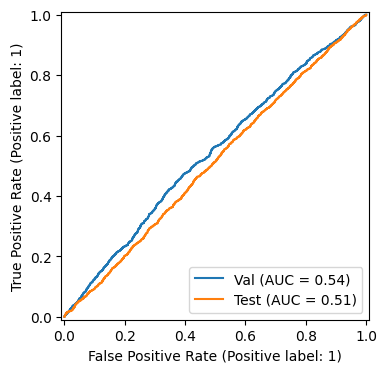

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# ROC curves
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
RocCurveDisplay.from_predictions(y_val, val_proba, name='Val', ax=ax)
RocCurveDisplay.from_predictions(y_test, test_proba, name='Test', ax=ax)
plt.show()